In [4830]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# -----------------------------------------------------------------------------------------------
# начальные значения
v0 = 200                                # начальная скорость БЦ, м/с

# theta - это угол между начальной скоростью и плоскостью xy,
# phi - угол между проекцией начальной скорости на плоскость xy и осью x.
theta = 30
phi = 20

geo_width = 55                          # геодезическая широта (тк нам не дано местоположение объекта)
geo_longitude = 60                      # геодезическая долгота

# тк в задании не даны начальная масса БЦ, и другие данные, чтобы посчитать баллистический коэффициент, 
# я приму gamma = 0,347 (нашла значения для пули)
# для более точных расчетов нужно в процессе полета пересчитывать это значение 
# (но тк начальных параметров нет, здесь я этого не делаю)
gamma = 0.347 
# -----------------------------------------------------------------------------------------------
# константы
a = 6378245                             # большая полуось Земли
b = 6356863                             # малая полуось Земли

GM = 3.986004418e14                     # произведение гравитационной постоянной Земли на массу
c_0 = 2.202095e10                       # коэффициент гравитационного поля Земли
omega = 7.292115e-5                     # угловая скорость вращения Земли
f = 298.3                               # коэффициент сжатия Земли
e_squared = (2*f-1)/((f - 1)**2)        # квадрат эксцентриситета Земли
# -----------------------------------------------------------------------------------------------
r = a/np.sqrt(1+(1/(1-1/f)**2 - 1)*(np.sin(geo_width))**2)                # расстояние от начала ГПСК до начала МЗСК
H = 1                                                                     # высота объекта над поверхностью эллипсоида

# ------------------------------------------------------------------------------------
# Формулы для пересчета из ГПСК в МЗСК
# ------------------------------------------------------------------------------------
sin_geo_width = np.sin(geo_width * (math.pi / 180))                                         
cos_geo_width = np.cos(geo_width * (math.pi / 180))
sin_geo_longitude = np.sin(geo_longitude * (math.pi / 180))
cos_geo_longitude = np.cos(geo_longitude * (math.pi / 180))

# матрица направляющих косинусов
A_mg = np.array([[-cos_geo_longitude*sin_geo_width, -sin_geo_longitude*sin_geo_width, cos_geo_width], 
                 [cos_geo_longitude*cos_geo_width, sin_geo_longitude*cos_geo_width, sin_geo_width], 
                 [sin_geo_longitude, cos_geo_longitude, 0]])

print(A_mg)

# геоцентрическая широта начала координат МЗСК
geocentric_latitude = np.arctan((1-1/f)**2 * np.tan(geo_width * (math.pi / 180)) * (math.pi / 180))

sin_geocentric_latitude = np.sin(geocentric_latitude * (math.pi / 180))
cos_geocentric_latitude = np.cos(geocentric_latitude * (math.pi / 180))

# координаты центра МЗСК в ГПСК
x_0 = np.array([r*cos_geocentric_latitude*cos_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                        r*cos_geocentric_latitude*sin_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                        r*sin_geocentric_latitude + H*sin_geo_width])

[[-0.40957602 -0.70940648  0.57357644]
 [ 0.28678822  0.49673176  0.81915204]
 [ 0.8660254   0.5         0.        ]]


In [4831]:
# -----------------------------------------------------------------------------------------------
# Функция, позволяющая получить первые и вторые производные координат
# -----------------------------------------------------------------------------------------------
def equations(coordinate, speed):
    x, y, z = coordinate
    vx, vy, vz = speed
    
    # вычисление первых производных 
    dx_dt = vx
    dy_dt = vy
    dz_dt = vz
    
    # учет ускорения свободного падения g_0
    r_0 = np.sqrt(x**2 + y**2 + z**2)
    A = GM/r_0**3
    B = (3*c_0)/r_0**2
    C = (15*c_0)/r_0**4
    D = (6*c_0)/r_0**2
    
    dvx_dt = -A*x + A*B*x - A*C*x*z**2
    dvy_dt = -A*y + A*B*y - A*C*y*z**2
    dvz_dt = -A*z + A*B*z + A*D*z - A*C*z**3
    
    # учет центростремительного ускорения БЦ
    dvx_dt += omega**2 * x
    dvy_dt += omega**2 * y
    dvz_dt += 0
    
    # учет кориолисова ускорения
    dvx_dt += 2 * omega * dy_dt
    dvy_dt += -2 * omega * dx_dt
    dvz_dt += 0
    
    # учет аэродинамического ускорения 
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    s = z/r_0                                     # синус широты цели
    h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
    rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 
               + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
    E = (-gamma * rho * v)/2
    
    dvx_dt += E * dx_dt
    dvy_dt += E * dy_dt
    dvz_dt += E * dz_dt
    
    return np.array([dx_dt, dy_dt, dz_dt, dvx_dt, dvy_dt, dvz_dt])


In [4832]:
# -------------------------------------------------------------------------------------
# Метод Рунге-Кутты 4 порядка
# 
# Шаг в методе Рунге-Кутты -- dt. Шаг выбирается так, чтобы обеспечить достаточную 
# точность вычислений отностительно времени вычисления (t_end).
# 
# -------------------------------------------------------------------------------------
def runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed):
    # h = t_end/dt
    t = t0
    coordinates = [initial_coordinate]
    speeds = [initial_speed]
    
    while t < t_end:
        coordinate = coordinates[-1]
        speed = speeds[-1]
        
        
        k1 = equations(coordinate, speed)
        q1 = speed
        k2 = equations(coordinate + dt/2 * q1, speed + dt/2 * k1[-3:])
        q2 = q1 + k1[-3:] * dt/2
        k3 = equations(coordinate + dt/2 * q2, speed + dt/2 * k2[-3:])
        q3 = q1 + k2[-3:] * dt/2
        k4 = equations(coordinate + dt * q3, speed + dt * k3[-3:])
        q4 = q1 + k3[-3:] * dt                             
        
        new_coordinate = coordinate + dt/6 * (q1 + 2*q2 + 2*q3 + q4)
        coordinates.append(new_coordinate)
        
        new_speed = speed + dt/6 * (k1[-3:] + 2*k2[-3:] + 2*k3[-3:] + k4[-3:])
        speeds.append(new_speed)

        t += dt #h
        
    return [np.array(coordinates), np.array(speeds)]


In [4833]:
# -------------------------------------------------------------------------------------
t0 = 0                      # начальный момент времени
t_end = 30               # конечный момент времени
dt = 1                     # шаг для метода рунге кутты
# -------------------------------------------------------------------------------------
# Основная функция для получения координат и их первых производных
# Здесь координаты и скорости получены в системе ГПСК, 
# далее осуществляется их перевод в МЗСК
# -------------------------------------------------------------------------------------
def get_result():

    
    initial_coordinate = np.array([x_0[0], x_0[1], x_0[2]])
    initial_speed = np.array([v0 * np.sin(theta * (math.pi / 180)) * np.cos(phi * (math.pi / 180)), 
                              v0 * np.sin(theta * (math.pi / 180)) * np.sin(phi * (math.pi / 180)), 
                              v0 * np.cos(theta * (math.pi / 180))])

    result = runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed)
    
    coordinate = result[0]
    speed = result[1]

    # извлечение координат и времени из результата
    x = coordinate[:, 0]
    y = coordinate[:, 1]
    z = coordinate[:, 2]
    vx = speed[:, 0]
    vy = speed[:, 1]
    vz = speed[:, 2]
    t = np.arange(t0, t_end + dt, dt)
    t_list = t.tolist()
    # print(initial_speed)
    return [x, y, z, vx, vy, vz, t_list] 
# print(get_result()[0])
# print(get_result()[1])
# print(get_result()[2])

# print(x_0)

# print(get_result()[2] - 2.74723374e+03)

In [4834]:
# -------------------------------------------------------------------------------------
# Перевод координат из ГПСК в МЗСК
# -------------------------------------------------------------------------------------
def recalculation_GPSK_MZSK(result):       
    iterations = len(result[0])
    # print(len)
    
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []
    xyz = []
    vx_vy_vz = []
    
    # Формирование списка координат и списка скоростей, переведенных в МЗСК
    for i in range(iterations):
        
        coordinates_g = np.array([result[0][i], result[1][i], result[2][i]])
        print(coordinates_g - x_0)
        coordinates_m = np.dot(A_mg, coordinates_g - x_0) 
        # print(coordinates_m)
        
        xyz.append(coordinates_m.tolist())
        x.append(xyz[i][0])
        y.append(xyz[i][1])
        z.append(xyz[i][2])     
        
        speeds_g = np.array([result[3][i], result[4][i], result[5][i]])
        speeds_m = np.dot(A_mg, speeds_g)
        
        if(i == 0):
            vx_vy_vz.append(speeds_g.tolist())
        else:
            vx_vy_vz.append(speeds_m.tolist())
        
        vx.append(vx_vy_vz[i][0])
        vy.append(vx_vy_vz[i][1])
        vz.append(vx_vy_vz[i][2])
        
        i += 1 
            
    return np.array([x, y, z, vx, vy, vz])

# recalculation_GPSK_MZSK(get_result())[0:3]


In [4835]:
# -------------------------------------------------------------------------------------
# Выделение из ответа координат и скоростей для последующих расчетов
# -------------------------------------------------------------------------------------
result = recalculation_GPSK_MZSK(get_result())
x = result[0]
y = result[1]
z = list(result[2])

vx = result[3]
vy = result[4]
vz = result[5]

t = get_result()[6]

# -------------------------------------------------------------------------------------
# Вычисление скорости и дальности в МЗСК 
# -------------------------------------------------------------------------------------
v = np.sqrt(vx**2 + vy**2 + vz**2) 
L = np.sqrt(x**2 + y**2) 
# -------------------------------------------------------------------------------------
# Находим когда z координата становится нулевой и обнуляем все данные для этой координаты
# Рассмотрение случая когда БЦ упала
# -------------------------------------------------------------------------------------
zeros_in_z = [i for i, s in enumerate(z) if s < 0]
zero_index_z = zeros_in_z[0]
print(zero_index_z)

length = len(x)
x[zero_index_z : length + 1] = [0] * (length - zero_index_z) 
y[zero_index_z : length + 1] = [0] * (length - zero_index_z)
z[zero_index_z : length + 1] = [0] * (length - zero_index_z)

L[zero_index_z : length + 1] = L[zero_index_z] * (length - zero_index_z)

vx[zero_index_z : length + 1] = [0] * (length - zero_index_z)
vy[zero_index_z : length + 1] = [0] * (length - zero_index_z)
vz[zero_index_z : length + 1] = [0] * (length - zero_index_z)
v[zero_index_z : length + 1] = [0] * (length - zero_index_z)
# -------------------------------------------------------------------------------------
# Составление таблицы с основными данными
# -------------------------------------------------------------------------------------
result_data = pd.DataFrame()

result_data['t'] = list(map(int, t))
result_data['x'] = list(map(int, x))
result_data['y'] = list(map(int, y))
result_data['z'] = list(map(int, z))
result_data['L'] = list(map(int, L))

result_data

# -------------------------------------------------------------------------------------
# Все расчеты проводятся в системе ГПСК(Гринвичская прямоугольная система координат). 
# Начало ГПСК находится в центре Земли.
# Далее полученные координаты и скорости переводятся в МЗСК - местная земная система координат
# -------------------------------------------------------------------------------------

[0. 0. 0.]
[ 90.38767836  29.56199098 171.08236026]
[173.70181168  49.98866761 337.93694988]
[250.09247263  61.50184096 500.62025469]
[319.72523401  64.32439672 659.22324776]
[382.77498789  58.67474786 813.86443128]
[439.42051848  44.76247643 964.68304559]
[ 489.84000531   22.78516199 1111.83285847]
[ 534.20750787   -7.07372194 1255.47681106]
[ 572.69038298  -44.64603731 1395.78266631]
[ 605.44751701  -89.77956701 1532.91969271]
[ 632.62821513 -142.33818681 1667.05632451]
[ 654.37157698 -202.20182712 1798.35867374]
[ 670.80619745 -269.26638042 1926.98972685]
[ 682.05005607 -343.44365386 2053.10904186]
[ 688.21049332 -424.66140866 2176.87276496]
[ 689.38420945 -512.86347853 2298.43380584]
[ 685.65725633 -608.00992188 2417.94204218]
[ 677.10502102 -710.07714035 2535.54445967]
[ 663.79222    -819.05788837 2651.38516976]
[ 645.7729338  -934.96110237 2765.60527867]
[  623.09071587 -1057.81149062  2878.34260601]
[  595.77880658 -1187.64884185  2989.73126938]
[  563.86047753 -1324.52703077  3

,t,x,y,z,L
0,0,0,0,0,0
1,1,40,180,93,185
2,2,87,351,175,362
3,3,141,512,247,531
4,4,201,663,309,693
5,5,268,805,360,849
6,6,341,938,402,998
7,7,420,1062,435,1142
8,8,506,1178,459,1282
9,9,597,1285,473,1417


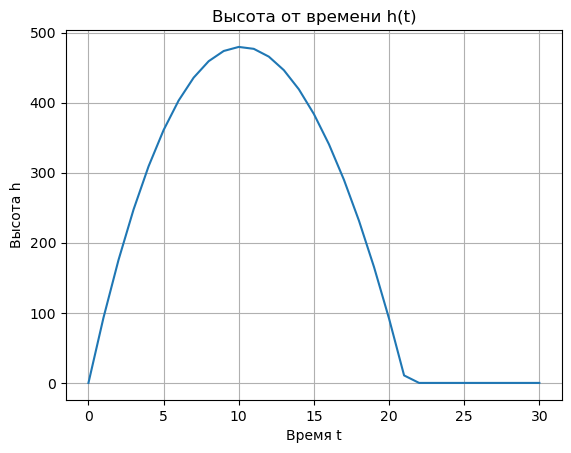

In [4836]:
# -------------------------------------------------------------------------------------
# Визуализация высоты от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t, z)
plt.xlabel('Время t')
plt.ylabel('Высота h')
plt.title('Высота от времени h(t)')
plt.grid(True)

plt.show()


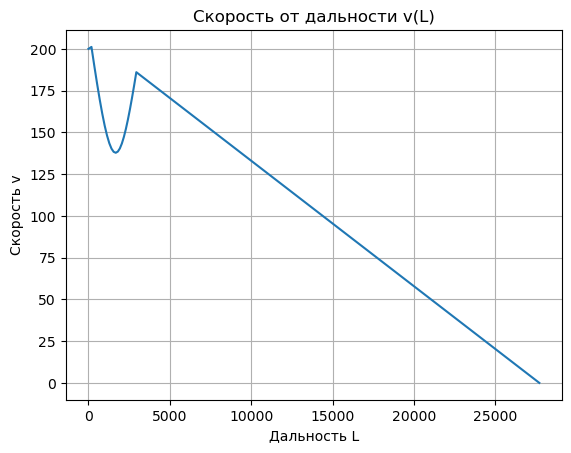

,t,vx,vy,vz,v,L
0,0,93,34,173,200,0
1,1,43,175,87,201,185
2,2,50,165,77,189,362
3,3,57,156,66,179,531
4,4,63,146,56,169,693
5,5,70,137,46,161,849
6,6,76,128,37,153,998
7,7,82,119,28,148,1142
8,8,88,111,18,143,1282
9,9,94,103,10,140,1417


In [4837]:
# -------------------------------------------------------------------------------------
# Визуализация скорости от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L, v)
plt.xlabel('Дальность L')
plt.ylabel('Скорость v')
plt.title('Скорость от дальности v(L)')
plt.grid(True)

plt.show()

# -------------------------------------------------------------------------------------
# Таблица скорости от дальности
# -------------------------------------------------------------------------------------
data = pd.DataFrame()
data['t'] = t
data['vx'] = list(map(int, vx))
data['vy'] = list(map(int, vy))
data['vz'] = list(map(int, vz))
data['v'] = list(map(int, v))
data['L'] = list(map(int, L))
data

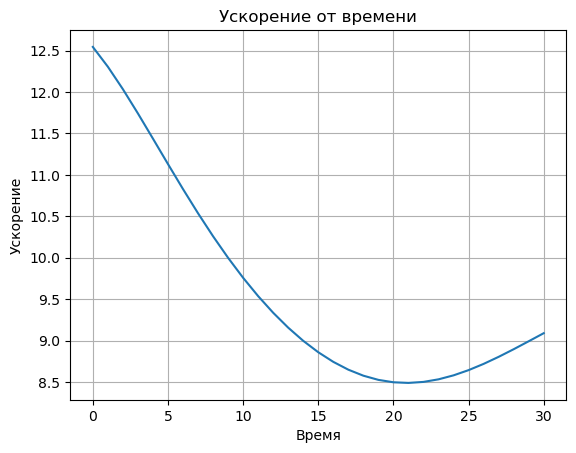

,g,L
0,12,0
1,12,185
2,12,362
3,11,531
4,11,693
5,11,849
6,10,998
7,10,1142
8,10,1282
9,9,1417


In [4838]:
# -------------------------------------------------------------------------------------
# Нахождение ускорения: вычисленные координаты подставляю в систему уравнения: 
# dx/dt = x'
# dx'/dt = g
# -------------------------------------------------------------------------------------
state_g = get_result()
x_g = state_g[0]
y_g = state_g[1]
z_g = state_g[2]

vx_g = state_g[3]
vy_g = state_g[4]
vz_g = state_g[5]

v_g = np.sqrt(vx_g**2 + vy_g**2 + vz_g**2)
r_0 = np.sqrt(x_g**2 + y_g**2 + z_g**2)

A = GM/r_0**3
B = (3*c_0)/r_0**2
C = (15*c_0)/r_0**4
D = (6*c_0)/r_0**2

s = z_g/r_0                                     # синус широты цели
h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли

rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 
            + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
E = (-gamma * rho * v_g)/2

g_0x = -A*x_g + A*B*x_g - A*C*x_g*z_g**2
g_0y = -A*y_g + A*B*y_g - A*C*y_g*z_g**2
g_0z = -A*z_g + A*B*z_g + A*D*z_g - A*C*z_g**3

g_cax = omega**2 * x_g
g_cay = omega**2 * y_g

g_corx = 2 * omega * vy_g
g_cory = - 2 * omega * vx_g

g_aerx = E * vx_g
g_aery = E * vy_g
g_aerz = E * vz_g

g_x =  g_0x + g_cax + g_corx + g_aerx
g_y =  g_0y + g_cay + g_cory + g_aery
g_z =  g_0z + g_aerz
    
g = np.sqrt(g_x**2 + g_y**2 + g_z**2)
# -------------------------------------------------------------------------------------
# Таблица ускорение, время, дальность
# -------------------------------------------------------------------------------------
acceleration_x = pd.DataFrame()
acceleration_x['t'] = t

acceleration_x['g_0x'] =  g_0x
acceleration_x['g_cax'] = g_cax
acceleration_x['g_corx'] = g_corx
acceleration_x['g_aerx'] = g_aerx
acceleration_x['g_x'] = g_x
# -------------------------------------------------------------------------------------
acceleration_y = pd.DataFrame()
acceleration_y['t'] = t

acceleration_y['g_y'] = list(map(int, g_y))
# -------------------------------------------------------------------------------------
acceleration_z = pd.DataFrame()
acceleration_z['g_z'] = list(map(int, g_z))

# -------------------------------------------------------------------------------------
acceleration = pd.DataFrame()
acceleration['g'] = list(map(int, g))

acceleration['L'] = list(map(int, L))
# -------------------------------------------------------------------------------------
# Визуализация ускорения от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t, g)
plt.xlabel('Время')
plt.ylabel('Ускорение')
plt.title('Ускорение от времени')
plt.grid(True)

plt.show()
acceleration

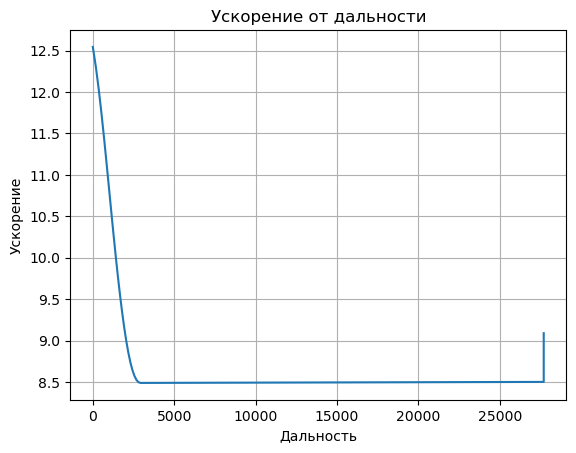

In [4839]:
# -------------------------------------------------------------------------------------
# Визуализация ускорения от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L, g)
plt.xlabel('Дальность')
plt.ylabel('Ускорение')
plt.title('Ускорение от дальности')
plt.grid(True)

plt.show()

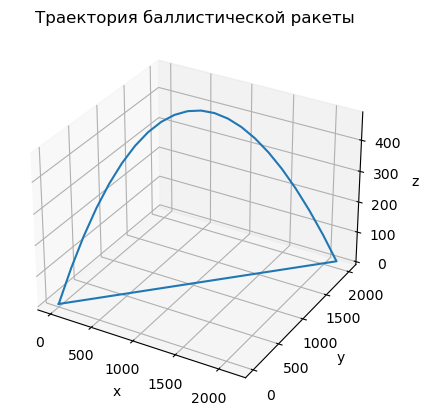

In [4840]:
# -------------------------------------------------------------------------------------
# Визуализация траектории ракеты в 3D
# -------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория баллистической ракеты')

plt.show()